# Theme 2 - Climate Variability, Ocean Circulation, and Ecosystem
## Ocean Circulation, Mixing, and Ecosystem
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on Nov 12, 2019. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download CTD and fluorometer data from an Endurance glider, and Bulk Meteorology data from an Endurance surface mooring using the Machine-to-Machine (M2M) interface, remove outliers, calculate depth-binned hourly averages, and export the data as a .csv file. We also demonstrate how to make a map of a glider track.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # for mapping
from mpl_toolkits.axes_grid1 import make_axes_locatable # for mapping
import cartopy.feature as cfeature # for mapping

## Request Data from OOINet

* **Coastal Endurance** - CTD and fluorometer data from Endurance Glider 320, and Sea Surface Temperature from the Endurance the Oregon Shelf Surface Mooring
    * Instruments, data streams, parameters:
        * CE05MOAS-GL320-05-CTDGVM000
            * ctdgv_m_glider_instrument_recovered: sci_water_pressure_dbar, sci_water_temp
        * CE05MOAS-GL320-02-FLORTM000
            * flort_m_sample: int_ctd_pressure, sci_flbbcd_chlor_units
        * CE02SHSM-SBD11-06-METBKA000
            * metbk_a_dcl_instrument_recovered: sea_surface_temperature
    * Time ranges: 
        * Glider: 2016-08-15T13:00 to 2016-08-24T09:00 (one transect on/offshore)
        * METBK: 2016-07-15 to 2016-09-15
    * Delivery method: recovered_host

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the three instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# CTD_url = request_data('CE05MOAS-GL320-05-CTDGVM000', 'recovered_host', 'ctdgv_m_glider_instrument_recovered',
#                        '2016-07-15T00:00:00.000Z', '2016-09-15T00:00:00.000Z')

# FLORT_url = request_data('CE05MOAS-GL320-02-FLORTM000', 'recovered_host', 'flort_m_sample',
#                          '2016-07-15T00:00:00.000Z', '2016-09-15T00:00:00.000Z')

# METBK_url = request_data('CE02SHSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2016-07-15T00:00:00.000Z', '2016-09-15T00:00:00.000Z')
# print('CTD_url: %s' %CTD_url)
# print('FLORT_url: %s' %FLORT_url)
# print('METBK_url: %s' %METBK_url)

## Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191112T165339508Z-CE05MOAS-GL320-05-CTDGVM000-recovered_host-ctdgv_m_glider_instrument_recovered/catalog.html'
FLORT_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191112T165339762Z-CE05MOAS-GL320-02-FLORTM000-recovered_host-flort_m_sample/catalog.html'
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191112T165340584Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for the three datasets. We want to get the latitude and longitude coordinates to make a map of the glider track.

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
CTD_var = ['sci_water_pressure_dbar', 'sci_water_temp', 'lat', 'lon']
FLORT_var = ['int_ctd_pressure', 'sci_flbbcd_chlor_units']
METBK_var = ['sea_surface_temperature', 'met_windavg_mag_corr_east', 'met_windavg_mag_corr_north']

CTD_data, CTD_units = get_data(CTD_url, CTD_var)
FLORT_data, FLORT_units = get_data(FLORT_url, FLORT_var)
METBK_data, METBK_units = get_data(METBK_url, METBK_var)
print(CTD_units)
print(FLORT_units)
print(METBK_units)

Appending data from files
Appending data from files
Appending data from files
{'sci_water_pressure_dbar': ['dbar'], 'sci_water_temp': ['ºC'], 'lat': ['degrees'], 'lon': ['degrees']}
{'int_ctd_pressure': ['dbar'], 'sci_flbbcd_chlor_units': ['µg L-1']}
{'sea_surface_temperature': ['ºC'], 'met_windavg_mag_corr_east': ['m s-1'], 'met_windavg_mag_corr_north': ['m s-1']}


In [8]:
# subset the glider dataframes for a time range that includes one transect on/offshore
CTD_data = CTD_data[(CTD_data['time'] > dt.datetime(2016, 8, 15, 13, 0, 0)) &
                   (CTD_data['time'] < dt.datetime(2016, 8, 24, 9, 0, 0))]

FLORT_data = FLORT_data[(FLORT_data['time'] > dt.datetime(2016, 8, 15, 13, 0, 0)) &
                       (FLORT_data['time'] < dt.datetime(2016, 8, 24, 9, 0, 0))]

In [9]:
CTD_data.head()

,time,sci_water_pressure_dbar,sci_water_temp,lat,lon
735037,2016-08-15 13:00:01.074489856,750.549988,4.1002,44.645867,-127.939425
735038,2016-08-15 13:00:03.291469824,750.869995,4.1003,44.645869,-127.939433
735039,2016-08-15 13:00:05.489990144,751.190063,4.1003,44.645871,-127.939441
735040,2016-08-15 13:00:07.744259584,751.489990,4.1001,44.645873,-127.939449
735041,2016-08-15 13:00:09.987210240,751.809998,4.0997,44.645874,-127.939457


## Plot Glider Track

Before we start looking at the glider data, let's plot the glider track on a map along with the locations of the Endurance Array moorings. Here is a function to return all of the locations of the Endurance moorings, using the Rutgers OOI Data Review Database.

In [10]:
def return_array_subsites_standard_loc(array):
    DBurl= 'https://datareview.marine.rutgers.edu/regions/view/{}.json'.format(array)
    r = requests.get(DBurl)
    url_ct = r.json()['region']['sites']
    loc_df = pd.DataFrame()
    for ii in range(len(url_ct)):
        if url_ct[ii]['reference_designator'] != 'CE05MOAS':
            data = {
                    'lat': url_ct[ii]['latitude'],
                    'lon': url_ct[ii]['longitude'],
                    'max_z': url_ct[ii]['max_depth']
                    }
            new_r = pd.DataFrame(data, columns=['lat', 'lon', 'max_z'], index=[url_ct[ii]['reference_designator']])
            loc_df = loc_df.append(new_r)
    return loc_df

In [11]:
array_loc = return_array_subsites_standard_loc('CE')
print(array_loc)

              lat      lon  max_z
CE01ISSM  44.6598 -124.095     25
CE01ISSP  44.6620 -124.096     25
CE02SHBP  44.6371 -124.306     79
CE02SHSM  44.6393 -124.304     80
CE02SHSP  44.6372 -124.299     81
CE04OSBP  44.3695 -124.954    579
CE04OSPD  44.3683 -124.953    576
CE04OSPS  44.3741 -124.956    588
CE04OSSM  44.3811 -124.956    588
CE06ISSM  47.1336 -124.272     29
CE06ISSP  47.1360 -124.269     29
CE07SHSM  46.9859 -124.566     87
CE07SHSP  46.9843 -124.565     87
CE09OSPM  46.8517 -124.982    544
CE09OSSM  46.8508 -124.972    542


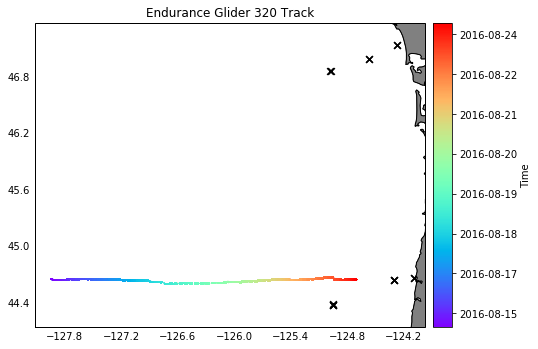

In [12]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.subplots_adjust(right=0.85)
states = cfeature.NaturalEarthFeature(category="cultural", scale="10m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black", facecolor='grey')
ax.add_feature(cfeature.RIVERS, zorder=10, facecolor='white')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = False
gl.ylines = False
ax.coastlines('10m', linewidth=1)
ax.set_title('Endurance Glider 320 Track')

lims = [-128.12, -123.97, 44.14, 47.37] # define the limits of the Endurance array
ax.set_extent(lims, crs=ccrs.PlateCarree())

londata = CTD_data['lon']
latdata = CTD_data['lat']
tm = CTD_data['time']

sct = plt.scatter(londata, latdata, c=tm, marker='.', s=2, cmap='rainbow', transform=ccrs.Geodetic())
plt.scatter(array_loc.lon, array_loc.lat, s=45, marker='x', color='k')  # add the mooring locations
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
fig.add_axes(cax)
cbar = plt.colorbar(sct, cax=cax, label='Time')
cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'));

During this time period, the glider started offshore and ran a relatively straight line perpendicular to shore on the Oregon line of the Endurance array off of Newport, OR.

## Quick Data Plots
Now, let's make some quick timeseries plots to look at the data. For gliders this isn't the best way to visualize the data because they are collected by depth, but this is just a way to quickly look at the data and see if there are any obvious issues. We will plot time on the x-axis, which in this case is roughly equivalent to longitude/distance from shore.

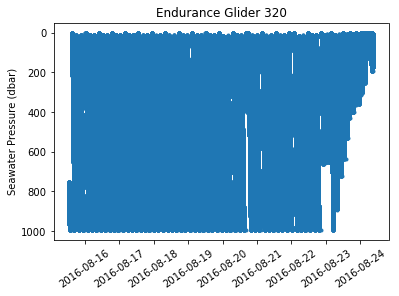

In [13]:
fig, ax = plt.subplots()
plt.plot(CTD_data['time'], CTD_data['sci_water_pressure_dbar'], '.')
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure ({})'.format(CTD_units['sci_water_pressure_dbar'][0]))
ax.set_title('Endurance Glider 320')
plt.xticks(rotation=35);

Looks like the glider profiled to approximately 1000 m. Now make a plot of temperature. Notice how the maximum glider depth got shallower the closer it moved to shore.

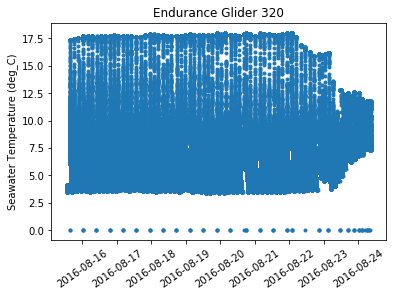

In [14]:
fig, ax = plt.subplots()
plt.plot(CTD_data['time'], CTD_data['sci_water_temp'], '.')
ax.set_xlabel('')
ax.set_ylabel('Seawater Temperature (deg_C)')
ax.set_title('Endurance Glider 320')
plt.xticks(rotation=35);

You can see in this plot that temperatures range from approximately 3-18 degrees Celsius (which makes sense as the glider is moving up and down in the water column), but there is also a weird line of values at zero. Slocum gliders use zero as a fill value when the glider is at the surface, so these values of 0.00 should be thrown out. Here is a function to remove values of 0.00 from the data frame:

In [15]:
# this function can only be used if the expected values are always >0
def remove_zeros(df, variables):
    cnames = []
    for v in variables:
        if v not in ['lat', 'lon']:
            cname = v + '_ind'
            cnames.append(cname)
            df[cname] = df[v] > 0.00
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

Plot temperature again to see if the 0.00 values were removed.

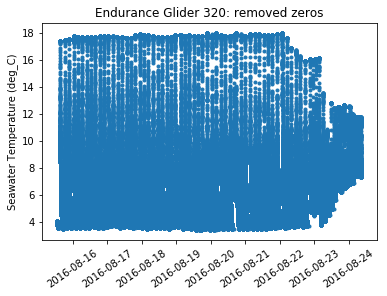

In [16]:
CTD_data = remove_zeros(CTD_data, CTD_var)

fig, ax = plt.subplots()
plt.plot(CTD_data['time'], CTD_data['sci_water_temp'], '.')
ax.set_xlabel('')
ax.set_ylabel('Seawater Temperature (deg_C)')
ax.set_title('Endurance Glider 320: removed zeros')
plt.xticks(rotation=35);

Looks good! Let's quickly plot the glider chlorophyll-a data.

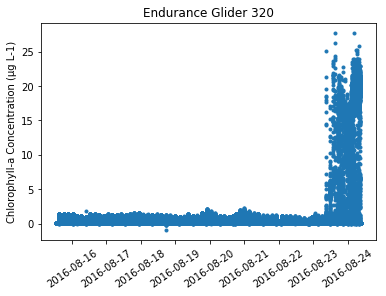

In [17]:
# quickly plot chl-a data
fig, ax = plt.subplots()
plt.plot(FLORT_data['time'], FLORT_data['sci_flbbcd_chlor_units'], '.')
ax.set_xlabel('')
ax.set_ylabel('Chlorophyll-a Concentration ({})'.format(FLORT_units['sci_flbbcd_chlor_units'][0]))
ax.set_title('Endurance Glider 320')
plt.xticks(rotation=35);

It looks like there are some negative chlorophyll values - these are within the noise range of the instrument but are invalid, so let's get rid of values less than zero with the same function we used above, and re-plot.

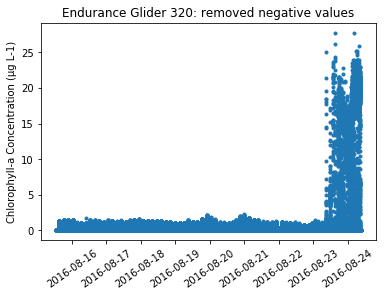

In [18]:
FLORT_data = remove_zeros(FLORT_data, FLORT_var)

fig, ax = plt.subplots()
plt.plot(FLORT_data['time'], FLORT_data['sci_flbbcd_chlor_units'], '.')
ax.set_xlabel('')
ax.set_ylabel('Chlorophyll-a Concentration ({})'.format(FLORT_units['sci_flbbcd_chlor_units'][0]))
ax.set_title('Endurance Glider 320: removed negative values')
plt.xticks(rotation=35);

Ok! Now that the glider data are cleaned up a bit, let's plot the sea surface temperature and wind data from the Endurance Oregon Shelf Surface Mooring.

In [19]:
METBK_data.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2016-07-15 00:00:17.510000128,13.954,1.745005,-10.805140
1,2016-07-15 00:01:21.761999872,13.961,3.401009,-9.467922
2,2016-07-15 00:02:27.759000064,13.963,-0.363599,-10.326195
3,2016-07-15 00:02:59.881999872,13.971,3.197829,-9.640020
4,2016-07-15 00:04:04.328000000,13.980,1.545006,-10.552751


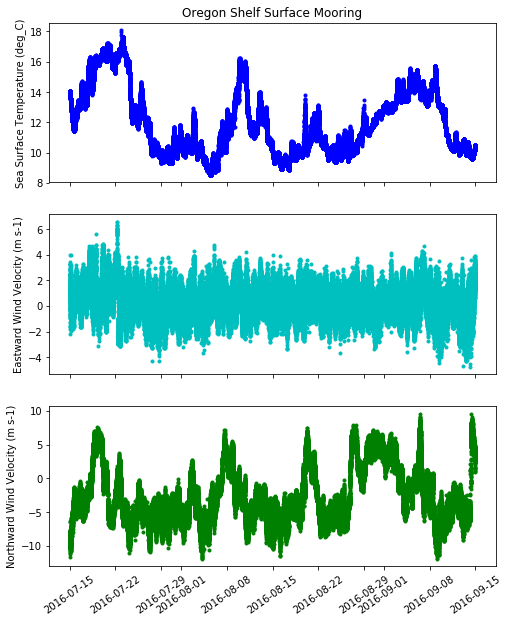

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize = (8, 10))
ax1.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b.')
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)')
ax1.set_title('Oregon Shelf Surface Mooring')

ax2.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_east'], 'c.')
ax2.set_xlabel('')
ax2.set_ylabel('Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]))

ax3.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g.')
ax3.set_xlabel('')
ax3.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))

plt.xticks(rotation=35);

## Explore winds
Sometimes it's useful to rotate winds to alongshore and offshore components in coastal areas to see how winds affect upwelling in the region. Fortunately, the Endurance array off of Oregon is in a region where the coastline runs north to south, so if you have northward and eastward winds you already have winds that are roughly parallel and perpendicular to the coast! If you are in a region where the coastline doesn't run directly north/south or east/west, Tom Connolly developed a [tutorial](https://github.com/tompc35/data-labs/blob/master/NDBC_wind_analysis.ipynb) that explains how to rotate winds to alongshore and offshore components. Check it out!

Since the OOI provides the processed u (met_windavg_mag_corr_east) and v (met_windavg_mag_corr_north) components of wind relative to true north, and the coastline runs approximately north/south, we can just look at v (northward wind velocity) to see which times would be favorable for upwelling. 

First, let's explore the data at bit more by plotting eastward vs northward winds to see which way the winds usually blow.

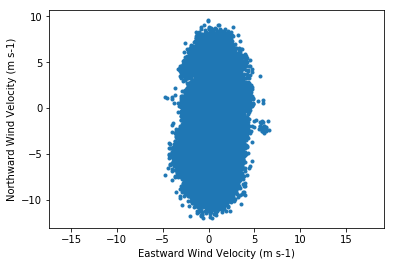

In [21]:
fig, ax = plt.subplots()
plt.plot(METBK_data['met_windavg_mag_corr_east'], METBK_data['met_windavg_mag_corr_north'], '.')
ax.set_xlabel('Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]))
ax.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))
plt.axis('equal'); # make the scale equal on the x and y axes

From this plot, winds generally blow directly north/south in this region, since on the west coast winds are typically steered parallel to the coastline. Winds blowing toward the south (negative northward wind velocity) are favorable for upwelling. 

Let's calculate hourly averages for the METBK dataset to make it more manageable, and explore the time where winds are blowing to the south.

In [22]:
METBK_hourly = METBK_data.resample('H', on='time').mean().dropna(how='all').reset_index()
METBK_hourly.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2016-07-15 00:00:00,14.033733,1.013180,-9.309861
1,2016-07-15 01:00:00,13.967683,1.125773,-9.299130
2,2016-07-15 02:00:00,13.713667,1.169908,-9.058700
3,2016-07-15 03:00:00,13.503783,1.165298,-9.295009
4,2016-07-15 04:00:00,13.229583,0.477293,-8.753698


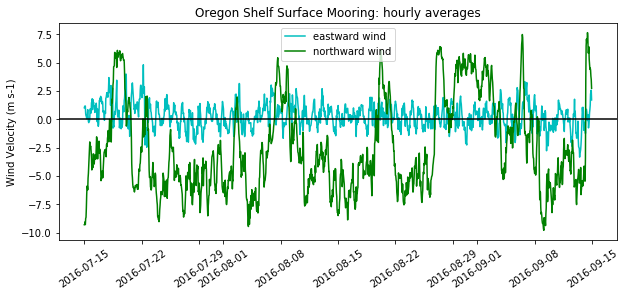

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(METBK_hourly['time'], METBK_hourly['met_windavg_mag_corr_east'], 'c', label='eastward wind')
plt.plot(METBK_hourly['time'], METBK_hourly['met_windavg_mag_corr_north'], 'g', label='northward wind')
ax.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))
ax.legend()
plt.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Shelf Surface Mooring: hourly averages')
plt.xticks(rotation=35);

In [24]:
# calculate the percentage of time during this time range that winds are blowing towards the south
north_winds = np.array(METBK_hourly['met_windavg_mag_corr_north'])
upwelling_percentage = len(north_winds[north_winds < 0]) / len(north_winds) * 100
print('{}%'.format(round(upwelling_percentage)))

74%


In this example, upwelling favorable conditions are the times where the northward wind component (green line) values are negative, which turns out to be about 74% of the time.

## Merge and export
Now let's work on exporting the datasets as .csv files. We will export the glider dataset in a separate .csv file from the METBK data from the surface mooring since the glider dataset is indexed by depth along with time. We'll do the METBK dataset first since we already calculated hourly averages.

In [25]:
# rename the columns and add units
METBK_hourly = METBK_hourly.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})
METBK_hourly.head()

,time,Sea Surface Temperature (deg_C),Eastward Wind Velocity (m s-1),Northward Wind Velocity (m s-1)
0,2016-07-15 00:00:00,14.033733,1.013180,-9.309861
1,2016-07-15 01:00:00,13.967683,1.125773,-9.299130
2,2016-07-15 02:00:00,13.713667,1.169908,-9.058700
3,2016-07-15 03:00:00,13.503783,1.165298,-9.295009
4,2016-07-15 04:00:00,13.229583,0.477293,-8.753698


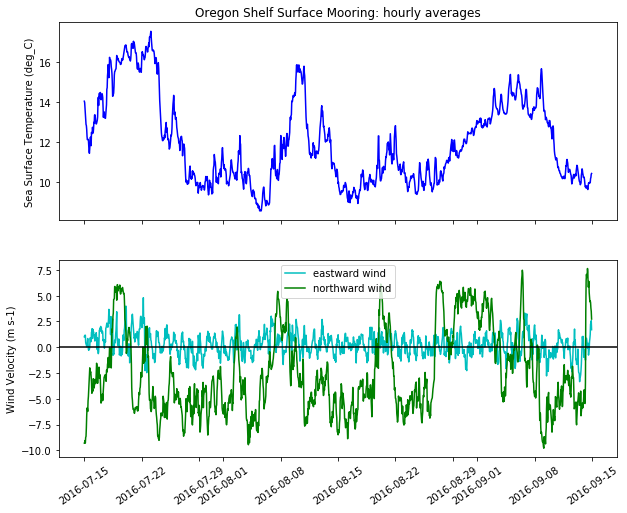

In [26]:
# Plot hourly-averaged METBK data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10, 8))
ax1.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], 'blue')
ax1.set_xlabel('')
ax1.set_ylabel('Sea Surface Temperature (deg_C)')
ax1.set_title('Oregon Shelf Surface Mooring: hourly averages')

ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind')
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

Let's plot northward winds vs SST, since both can indicate upwelling conditions.

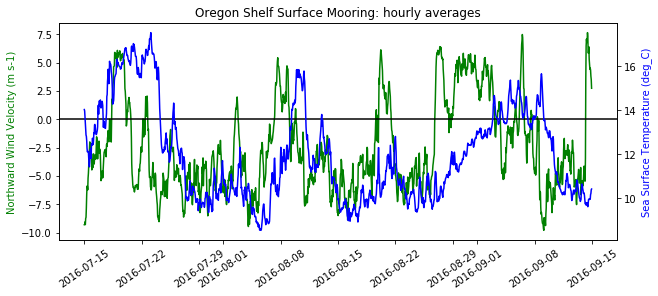

In [27]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g')
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g')
plt.xticks(rotation=35)

ax2 = ax.twinx()  # instantiate a second axis that shares the same x-axis
ax2.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], 'blue')
ax2.set_ylabel('Sea Surface Temperature (deg_C)', color='blue')

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Shelf Surface Mooring: hourly averages');

In general, when northward wind velocity (green line) is below the black horizontal line (southward-blowing winds, favorable upwelling conditions), SST decreases - indicating cold subsurface water is being upwelled to the surface. When winds shift to the north, SST gradually increases. 

Let's export this dataset to csv.

In [22]:
# export to .csv
METBK_hourly.to_csv(os.path.join(save_dir, 'Theme2b_Endurance_METBK.csv'), index=False)

Now let's focus on the glider data. First, we want to downsample this dataset since it's very high-resolution (about 1 sample every 2 seconds). This example will demonstrate how to calculate averages by 1 dbar depth bins by hour (so we retain the time series format). This section of code will take a few seconds to complete.

In [28]:
# cut off the minutes and seconds in the time stamp
CTD_data['time'] = CTD_data['time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))

# create a new column in the dataframe with pressure rounded to the nearest 1 dbar
CTD_data['Pressure Bin (dbar)'] = (round(CTD_data['sci_water_pressure_dbar']))

# calculate depth-binned averages by time
CTD_data_binned = CTD_data.groupby(['time', 'Pressure Bin (dbar)']).mean()

# repeat for the fluorometer dataset
FLORT_data['time'] = FLORT_data['time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))
FLORT_data['Pressure Bin (dbar)'] = (round(FLORT_data['int_ctd_pressure']))
FLORT_data_binned = FLORT_data.groupby(['time', 'Pressure Bin (dbar)']).mean()

In [29]:
# merge the two datasets on time and pressure bin, and make sure the resulting dataframe is sorted by time
glider_data = pd.merge(CTD_data_binned, FLORT_data_binned, on=['time', 'Pressure Bin (dbar)'], how='outer').reset_index()
glider_data = glider_data.sort_values(['time', 'Pressure Bin (dbar)'])
glider_data = glider_data.drop(columns=['sci_water_pressure_dbar', 'int_ctd_pressure'])

# rename the columns and add units
glider_data = glider_data.rename(columns={'sci_water_temp': 'Seawater Temperature (deg_C)',
                                          'lat': 'Latitude ({})'.format(CTD_units['lat'][0]),
                                          'lon': 'Longitude ({})'.format(CTD_units['lon'][0]),
                                          'sci_flbbcd_chlor_units': 'Chl-a Concentration ({})'.format(FLORT_units['sci_flbbcd_chlor_units'][0])})
# convert time from a object to a datetime
glider_data['time'] = glider_data['time'].apply(lambda t: dt.datetime.strptime(t, '%Y-%m-%d %H'))

# print the first few lines of the new merged dataframe
glider_data.head()

,time,Pressure Bin (dbar),Seawater Temperature (deg_C),Latitude (degrees),Longitude (degrees),Chl-a Concentration (µg L-1)
0,2016-08-15 13:00:00,751.0,4.100225,44.645870,-127.939437,0.07200
1,2016-08-15 13:00:00,752.0,4.099300,44.645874,-127.939462,0.05472
2,2016-08-15 13:00:00,753.0,4.093233,44.645877,-127.939485,0.07320
3,2016-08-15 13:00:00,754.0,4.086333,44.645879,-127.939504,0.06192
4,2016-08-15 13:00:00,755.0,4.077100,44.645882,-127.939525,0.06600


Now that we have our downsampled and merged dataframe, let's plot the variables again in a different way that makes more sense for glider data.

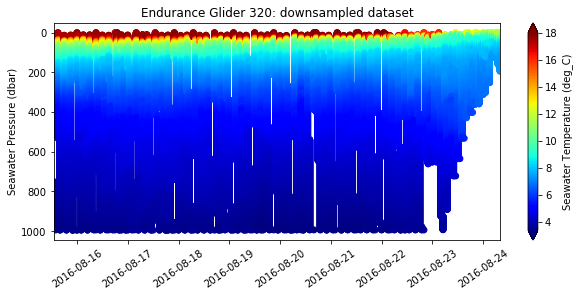

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
xc = ax.scatter(np.array(glider_data['time']), glider_data['Pressure Bin (dbar)'], 
                c=glider_data['Seawater Temperature (deg_C)'], cmap='jet')
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure (dbar)')
bar = fig.colorbar(xc, ax=ax, label='Seawater Temperature (deg_C)', extend='both')
ax.set_title('Endurance Glider 320: downsampled dataset')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(glider_data['time']), np.nanmax(glider_data['time'])]);

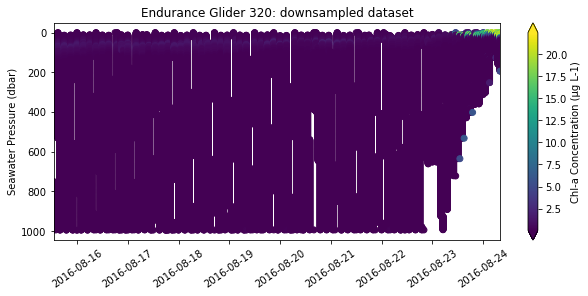

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
xc = ax.scatter(np.array(glider_data['time']), glider_data['Pressure Bin (dbar)'], 
                c=glider_data['Chl-a Concentration (µg L-1)'])
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure (dbar)')
bar = fig.colorbar(xc, ax=ax, label='Chl-a Concentration (µg L-1)', extend='both')
ax.set_title('Endurance Glider 320: downsampled dataset')
plt.xticks(rotation=35)
# set the x limits to the min and max timestamp to get rid of extra white space in the graph
plt.xlim([np.nanmin(glider_data['time']), np.nanmax(glider_data['time'])]);

In these graphs we can see where the glider get's closer to shore (e.g. when the maximum glider depth gets shallower), seawater temperatures at the surface are colder than they are offshore. This agrees with the METBK data showing lower SST at the surface mooring closer inshore during times of winds blowing towards the south. All of these data indicate that upwelling is occurring in this region. The high phytoplankton biomass captured by the glider in the nearshore region could be fueled by the cold nutrient-rich waters being upwelled from below.

This glider dataset looks good, so we can export it as a .csv file.

In [32]:
glider_data.to_csv(os.path.join(save_dir, 'Theme2b_Endurance_glider_data_depthavg.csv'), index=False)